# **VAR Model**

The water level of the Lake of Zurich depends on multiple variables. Thus, we have decided to try to predict it through a multivariate time series model: the Vector Autoregressive Model (VAR). This is used when multiple time series have a reciprocal influence. 
Even in this case we are only using weekly and monthly data, since the variations in the daily data were too small.

STRUCTURE:
1. VAR Model for weekly data.
2. VAR Model for monthly data.

CONTENT:

This notebook contains to important analyzes: the Johansen’s Co-Integration Test and the Granger's causality test. 

With the Johansen’s Co-Integration Test it is possible to establish if multiple time series have a long run significant relationship. This means that changes in the short-run would converge in the long-term.

The Granger's causlity test, on the other hand, permits us to check whether multiple variables reciprocally Granger cause themselves. Thus, if certain values are useful to predict one-another.


SOURCES:

For the VAR model:

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

https://medium.com/hamoye-blogs/using-vector-auto-regression-to-model-bitcoin-prices-6cae0327ac30

For Granger's causality:

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2

For Johansen's Co-integration:

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

http://cruncheconometrix.blogspot.com/2018/03/time-series-analysis-lecture-4-part-1.html


# Main packages, functions and datasets

In [1]:
#Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from pmdarima.model_selection import train_test_split
warnings.filterwarnings('ignore') 

In [2]:
#ADF test
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [3]:
#Cointegration test
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [4]:
#Granger's causality
from statsmodels.tsa.stattools import grangercausalitytests

# defining a function to return a dataframe of the results of
# Granger's causality test
def get_grangers_causation_results(df, maxlag, test='ssr_chi2test'):
    results = []
    
    for row in df.columns:
        row_result = []
        
        for col in df.columns:
            test_result = grangercausalitytests(df[[col, row]],   maxlag=maxlag, verbose=False) # gets causality results
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)] # gets p values
            min_p_value = np.min(p_values)
            row_result.append(min_p_value)
            
        results.append(row_result)
        
    ind = [i + '_x' for i in df.columns] # creates indices of the dataframe from the columns of df with a '_x' suffix
    cols = [i + '_y' for i in df.columns] # creates column names of the dataframe from the columns of df with a '_y' suffix
    
    return pd.DataFrame(np.array(results), index=ind, columns=cols)

In [5]:
# creating a walk forward fuction 
def walk_forward_VAR(train, test, lag_order, data):
 
    # makes a list of lists from the train set
    history = [list(x) for x in np.array(train)] 
    forecasts = [] # empty list to store our forecasts
    
    for t in range(test.shape[0]): # for each test set,
        # initialize a VAR model on the train set,
        model = VAR(np.array(history)) 
        model_fit = model.fit(lag_order) # fits the model
        
        # forecast just the next time step
        yhat = model_fit.forecast(model.y, steps=1)
        
        # add the forecast to the forecasts list
        forecasts.append(list(yhat[0])) 
        
        # add the actual test value as the last observation of the 
        # train set
        history.append(list(np.array(test)[t])) 
            
    # return a tuple of the test set and the predicited test set as
    # a tuple of dataframes 
    return test, pd.DataFrame(np.array(forecasts), index=test.index, columns=data.columns)

In [6]:
#Function to invert differenced data
def invert_transformation(df, df_forecast, first_diff=False): 
    dvar_fc = df_forecast.copy()
    columns = df.columns
    for col in columns:        
        dvar_fc[col] = df[col].iloc[-1] + dvar_fc[col].cumsum() #we take the last element of the original dataset that we use to forecast and we make the cumulative sum of the forecast
    return dvar_fc

In [7]:
# function for calculating different performance measures, namely the MAE, MSE, MAPE and the R-squared

from sklearn.metrics import mean_absolute_error as mae
import numpy as np
from sklearn.metrics import r2_score

def mean_errors(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAE = mae(actual, pred)
    MSE = np.square(np.subtract(actual,pred)).mean()
    MAPE = np.mean(np.abs((actual - pred) / actual)) * 100
    R2_score = r2_score(actual, pred)
    return print("MAE: {} \nMSE: {} \nMAPE: {} \nR2: {}".format(MAE, MSE, MAPE, R2_score))

In [8]:
## import and prepare montly data

monthly_data = pd.read_csv("../Data/clean_data/monthly_data.csv")
# convert DateTime column into datetime format
monthly_data["datetime"] = pd.to_datetime(monthly_data['datetime'])
# set DateTime as index
monthly_data.set_index("datetime", inplace=True)


## import and prepare weekly data

weekly_data = pd.read_csv("../Data/clean_data/weekly_data.csv")
# convert DateTime column into datetime format
weekly_data["datetime"] = pd.to_datetime(weekly_data['datetime'])
# set DateTime as index
weekly_data.set_index("datetime", inplace=True)

# VAR Model - Weekly Data

**1. Loading and Visualizing the data**

In [9]:
#Import the dataset and drop NAN values
weekly_data = weekly_data.dropna()

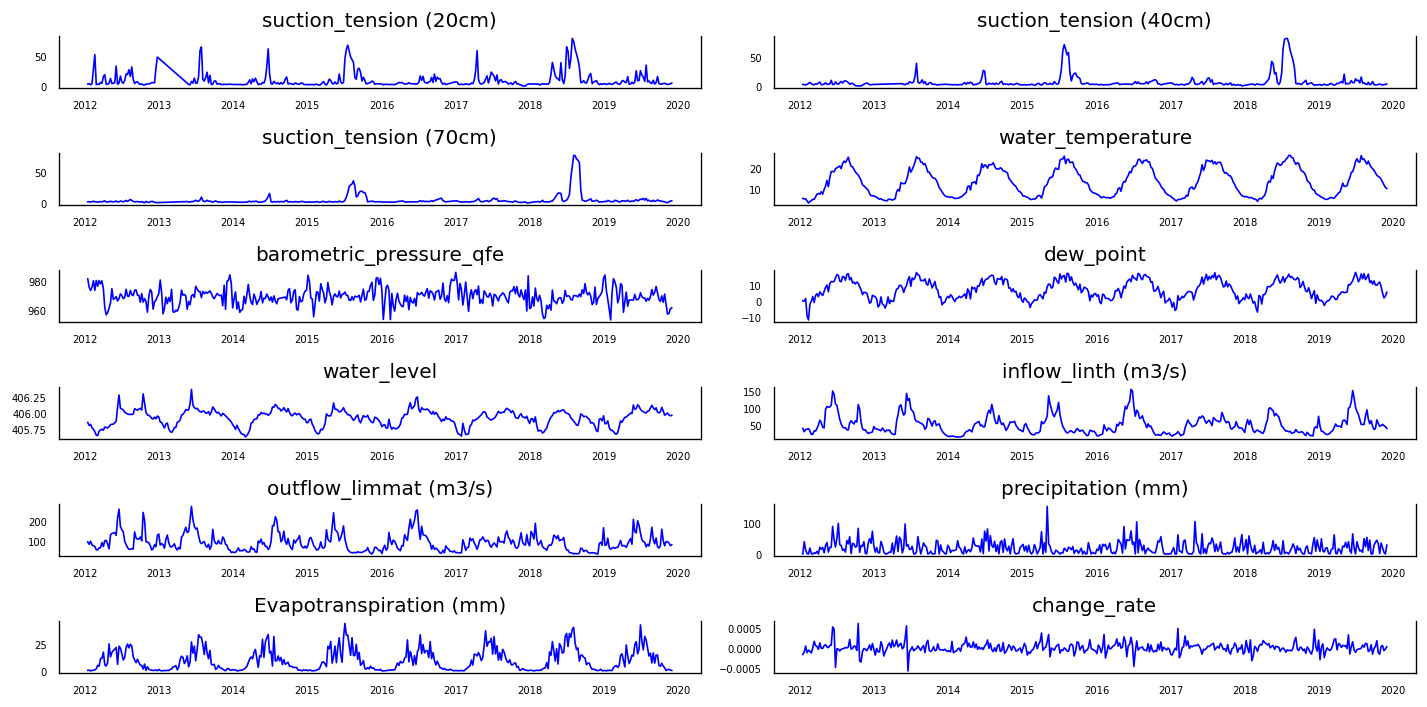

In [10]:
#Plot all variables
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    weekly_data2 = weekly_data[weekly_data.columns[i]]
    ax.plot(weekly_data2, color='blue', linewidth=1)
    # Decorations
    ax.set_title(weekly_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Through the plots we could hypothesize that there is some seasonality. One way to verify it, is through the Augmented Dickey-Fuller (ADF) test.

**2. Testing the stationarity by using ADF and differencing the data**

In [11]:
for name, column in weekly_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7781
 No. Lags Chosen       = 4
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4793
 No. Lags Chosen       = 6
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has 

The ADF test states that all variables are stationary. However, since the monthly data (see later in the notebook) is stationary and the ADF test can be decieving, we are going to difference the data anyways in order to be sure that it is actually stationary. 

In [12]:
#Let's difference the dataset in order to be sure that the data is stationary
weekly_data_differenced = weekly_data.diff().dropna()

**3. Testing cointegration**

Through the cointegration test it is possible to determine important statistical relations between the variables.

In [13]:
cointegration_test(weekly_data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
suction_tension (20cm) ::  829.9     > 311.1288  =>   True
suction_tension (40cm) ::  685.88    > 263.2603  =>   True
suction_tension (70cm) ::  562.26    > 219.4051  =>   True
water_temperature ::  452.3     > 179.5199  =>   True
barometric_pressure_qfe ::  358.72    > 143.6691  =>   True
dew_point ::  279.23    > 111.7797  =>   True
water_level ::  206.4     > 83.9383   =>   True
inflow_linth (m3/s) ::  143.2     > 60.0627   =>   True
outflow_limmat (m3/s) ::  87.65     > 40.1749   =>   True
precipitation (mm) ::  45.21     > 24.2761   =>   True
Evapotranspiration (mm) ::  19.73     > 12.3212   =>   True
change_rate ::  0.18      > 4.1296    =>   False


As we can see, almost all variables are cointegrating.

**4. Split the data into train, validation and test set.**

In [103]:
#Let's keep a copy of the undifferenced train, validation and test sets. This is going to be useful when inverting the data.
train, test = train_test_split(weekly_data, train_size=364) #train: 2012-2019, test (unseen data): 2019-2020
train_val, val = train_test_split(train, train_size=259) #train_val: 2012- (end of 2017), val (validation set): 2017- (end of) 2018

In [74]:
#Let's know difference the data
train_differenced, test_differenced = train_test_split(weekly_data_differenced, train_size=363)
train_val_differenced, val_differenced = train_test_split(train_differenced, train_size=258)

**5. Checking the AIC score**

In [75]:
from statsmodels.tsa.vector_ar.var_model import VAR #import VAR
model_VAR = VAR(train_val_differenced) #initialize VAR 
model_VAR.select_order(maxlags=10).summary()

,AIC,BIC,FPE,HQIC
0,9.548,9.718,1.401e+04,9.616
1,-7.078,-4.868*,0.0008447,-6.188*
2,-7.508,-3.258,0.0005532,-5.797
3,-7.648,-1.358,0.0004899*,-5.116
4,-7.644,0.6864,0.0005102,-4.290
5,-7.406,2.964,0.0006876,-3.231
6,-7.262,5.148,0.0008703,-2.266
7,-7.239,7.211,0.001015,-1.422
8,-7.450,9.040,0.0009857,-0.8118
9,-7.647,10.88,0.001032,-0.1872


From the results, we can see that the lowest AIC is obtained when the lag order is equal to 3. However, we are also going to test the model with lower and higher values. In this case, the best errors were returned with a lag order = 4.

**6.1 Fitting the model with Walking Forward and the original test set (without testing Granger's causality)**

In [78]:
#Let's apply the walking forward approach using the train set for the validation. This is going to return the prediction for the validation set and the validation set itself.
VAR_wf_we_test_diff, VAR_wf_we_val_diff = walk_forward_VAR(train_val_differenced, val_differenced, 4, weekly_data)

In [80]:
#Now we need to invert the transformation. In this case, we are using the function invert_transformation (see beginning of the notebook).
#Inverting the differenced values can lead to a small error of approximation, however this is the method that has been indicated also by multiple resources.
train_validation_wf_inverted = invert_transformation(train_val, VAR_wf_we_test_diff, first_diff=True) #validation set inverted
wf_validation_inverted = invert_transformation(train_val, VAR_wf_we_val_diff, first_diff=True) #forecast for validation set inverted.

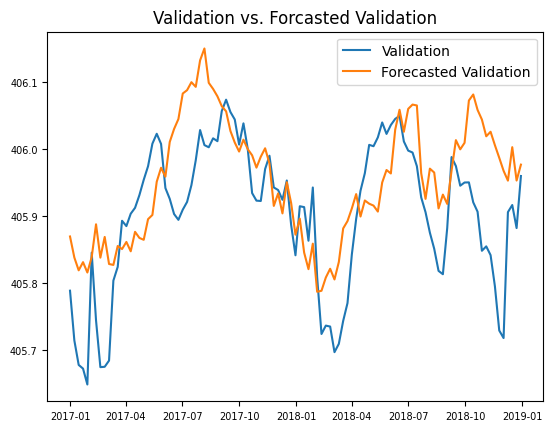

In [81]:
#Let's represent our forecasted validation set and our validation set by using the inverted values.
import matplotlib.pyplot as plt
plt.plot(train_validation_wf_inverted[["water_level"]].index, train_validation_wf_inverted[["water_level"]], label="Validation")
plt.plot(wf_validation_inverted[["water_level"]].index, wf_validation_inverted[["water_level"]], label="Forecasted Validation")
plt.title("Validation vs. Forcasted Validation")
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.legend()
plt.show()

In [82]:
#Let's return the errors for the model. We are going to use the inverted validation set and the inverted forecast for the validation set (of course only for the water level).
mean_errors(train_validation_wf_inverted[["water_level"]], wf_validation_inverted[["water_level"]])

MAE: 0.08009386952948089 
MSE: 0.009745298870709804 
MAPE: 0.019734251560924263 
R2: 0.15399462301185396


**6.2 Fitting the model with Walking Forward and the selected test set (with testing Granger's causality)**

First we are going to test Granger's causality. We are going to fit the oprimal lag order (the one we selected after numerous attempts).

In [83]:
#The rows are the predictors and the columns the response.
get_grangers_causation_results(train_differenced, 4, test='ssr_chi2test')

,suction_tension (20cm)_y,suction_tension (40cm)_y,suction_tension (70cm)_y,water_temperature_y,barometric_pressure_qfe_y,dew_point_y,water_level_y,inflow_linth (m3/s)_y,outflow_limmat (m3/s)_y,precipitation (mm)_y,Evapotranspiration (mm)_y,change_rate_y
suction_tension (20cm)_x,1.0000,0.0005,0.0001,0.0171,0.5484,0.4356,0.3460,0.7839,0.2509,0.0131,0.0154,0.5721
suction_tension (40cm)_x,0.0013,1.0000,0.0000,0.8194,0.3733,0.1714,0.2263,0.3582,0.1452,0.0532,0.2205,0.4728
suction_tension (70cm)_x,0.1353,0.0000,1.0000,0.3354,0.4651,0.1227,0.4597,0.9867,0.4910,0.0536,0.0475,0.1238
water_temperature_x,0.3256,0.5599,0.1550,1.0000,0.3954,0.0000,0.0166,0.0279,0.2050,0.3763,0.0219,0.5734
barometric_pressure_qfe_x,0.0186,0.3151,0.7840,0.2425,1.0000,0.0493,0.0650,0.2973,0.0159,0.1301,0.1209,0.0310
dew_point_x,0.0305,0.5055,0.5624,0.0001,0.7000,1.0000,0.0009,0.0002,0.0007,0.7021,0.2089,0.0172
water_level_x,0.4791,0.2154,0.6181,0.0002,0.0360,0.0075,1.0000,0.1066,0.1105,0.0000,0.0005,0.0000
inflow_linth (m3/s)_x,0.8008,0.7016,0.8047,0.0183,0.3141,0.0550,0.3430,1.0000,0.0025,0.0001,0.0400,0.0000
outflow_limmat (m3/s)_x,0.7665,0.7122,0.6455,0.0886,0.0576,0.4031,0.0004,0.0073,1.0000,0.0000,0.0007,0.0000
precipitation (mm)_x,0.0404,0.1691,0.0699,0.0457,0.1518,0.2260,0.0000,0.0000,0.0000,1.0000,0.4147,0.0000


After this analysis we will keep the following variables: water temperature, barometric pressure, dew point, outflow, precipitation, evapotranspiration and change rate.
Let's therefore drop the other variables.
The decision to choose these specific variables comes from selecting those that affect the most the water level.

In [84]:
train1 = train[["water_temperature", "barometric_pressure_qfe", "dew_point", "water_level", "outflow_limmat (m3/s)", "precipitation (mm)", "Evapotranspiration (mm)", "change_rate"]]
test1 = test[["water_temperature", "barometric_pressure_qfe", "dew_point", "water_level", "outflow_limmat (m3/s)", "precipitation (mm)", "Evapotranspiration (mm)", "change_rate"]]
train_val1 = train_val[["water_temperature", "barometric_pressure_qfe", "dew_point", "water_level", "outflow_limmat (m3/s)", "precipitation (mm)", "Evapotranspiration (mm)", "change_rate"]]
val1 = val[["water_temperature", "barometric_pressure_qfe", "dew_point", "water_level", "outflow_limmat (m3/s)", "precipitation (mm)", "Evapotranspiration (mm)", "change_rate"]]
train_difference1 = train_differenced[["water_temperature", "barometric_pressure_qfe", "dew_point", "water_level", "outflow_limmat (m3/s)", "precipitation (mm)", "Evapotranspiration (mm)", "change_rate"]]
test_differenced1 = test_differenced[["water_temperature", "barometric_pressure_qfe", "dew_point", "water_level", "outflow_limmat (m3/s)", "precipitation (mm)", "Evapotranspiration (mm)", "change_rate"]]
train_val_differenced1 = train_val_differenced[["water_temperature", "barometric_pressure_qfe", "dew_point", "water_level", "outflow_limmat (m3/s)", "precipitation (mm)", "Evapotranspiration (mm)", "change_rate"]]
val_differenced1 = val_differenced[["water_temperature", "barometric_pressure_qfe", "dew_point", "water_level", "outflow_limmat (m3/s)", "precipitation (mm)", "Evapotranspiration (mm)", "change_rate"]]
weekly_data1 = weekly_data[["water_temperature", "barometric_pressure_qfe", "dew_point", "water_level", "outflow_limmat (m3/s)", "precipitation (mm)", "Evapotranspiration (mm)", "change_rate"]]

In [85]:
#Let's fit the model and invert the data to non-differenced
VAR_wf_we_test_diff1, VAR_wf_we_val_diff1 = walk_forward_VAR(train_val_differenced1, val_differenced1, 4, weekly_data1)
train_wf_validation_inverted1 = invert_transformation(train_val1, VAR_wf_we_test_diff1, first_diff=True)
wf_validation_inverted1 = invert_transformation(train_val1, VAR_wf_we_val_diff1, first_diff=True)

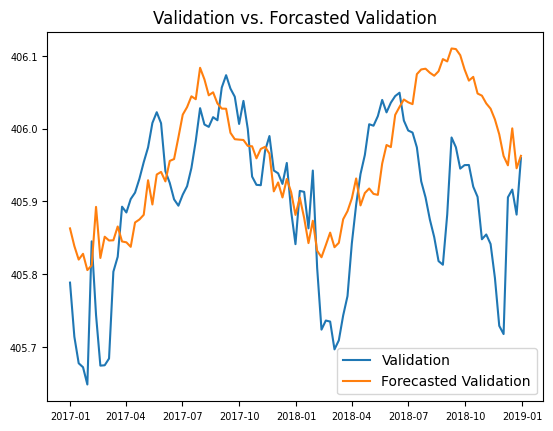

In [86]:
#Let's represent the inverted validation set and the forecasted validation
import matplotlib.pyplot as plt
plt.plot(train_wf_validation_inverted1[["water_level"]].index, train_wf_validation_inverted1[["water_level"]], label="Validation")
plt.plot(wf_validation_inverted1[["water_level"]].index, wf_validation_inverted1[["water_level"]], label="Forecasted Validation")
plt.title("Validation vs. Forcasted Validation")
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.legend()
plt.show()

In [87]:
mean_errors(train_wf_validation_inverted1[["water_level"]], wf_validation_inverted1[["water_level"]])

MAE: 0.08865411964697961 
MSE: 0.012075938872608598 
MAPE: 0.02184351113861451 
R2: -0.048332057738413425


**7. Final testing VAR Model - Weekly**

Let's now test our models on the unseen data.

In [88]:
#This is the forecast with the VAR weekly (without variable selection)
test_diff_we, forecast_diff_we = walk_forward_VAR(train_differenced, test_differenced, 4, weekly_data)
test_diff_we_inverted = invert_transformation(train, test_diff_we, first_diff=True)
forecast_diff_we_inverted = invert_transformation(train, forecast_diff_we, first_diff=True)

In [97]:
#This is the foecast with the VAR weekly (with variable selection)
#Let's fit the model and invert the data to non-differenced
test_diff_we_g, forecast_diff_we_g = walk_forward_VAR(train_difference1, test_differenced1, 4, weekly_data1)
test_diff_we_g_inverted = invert_transformation(train1, VAR_wf_we_test_diff1, first_diff=True)
forecast_diff_we_g_inverted = invert_transformation(train1, forecast_diff_we_g, first_diff=True)

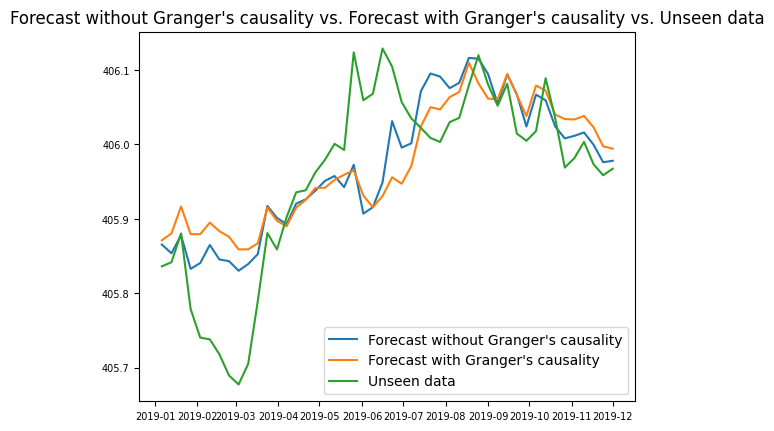

In [90]:
#Let's represent the inverted validation set and the forecasted validation
import matplotlib.pyplot as plt
plt.plot(forecast_diff_we_inverted[["water_level"]].index, forecast_diff_we_inverted[["water_level"]], label="Forecast without Granger's causality")
plt.plot(forecast_diff_we_g_inverted[["water_level"]].index, forecast_diff_we_g_inverted[["water_level"]], label="Forecast with Granger's causality")
plt.plot(test[["water_level"]].index, test[["water_level"]], label="Unseen data")
plt.title("Forecast without Granger's causality vs. Forecast with Granger's causality vs. Unseen data")
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.legend()
plt.show()

In order to calculate the error, we are going to use as a reference the pure test data (so not the reinverted differenced test data).

In [91]:
#Let's calculate the errors for the model with all variables
mean_errors(test[["water_level"]], forecast_diff_we_inverted[["water_level"]])

MAE: 0.056403476327923606 
MSE: 0.005635762694927819 
MAPE: 0.013894921968787404 
R2: 0.6333573075181217


In [92]:
#Let's calculate the errors for the model with the selected variables
mean_errors(test[["water_level"]], forecast_diff_we_g_inverted[["water_level"]])

MAE: 0.066451706370664 
MSE: 0.007576959040520948 
MAPE: 0.016370679097620272 
R2: 0.5070699719238108


# VAR Model - Monthly data, all variables

**1. Visualizing and loading the Data**

In [31]:
#Let's drop all NAN values
monthly_data = monthly_data.dropna()

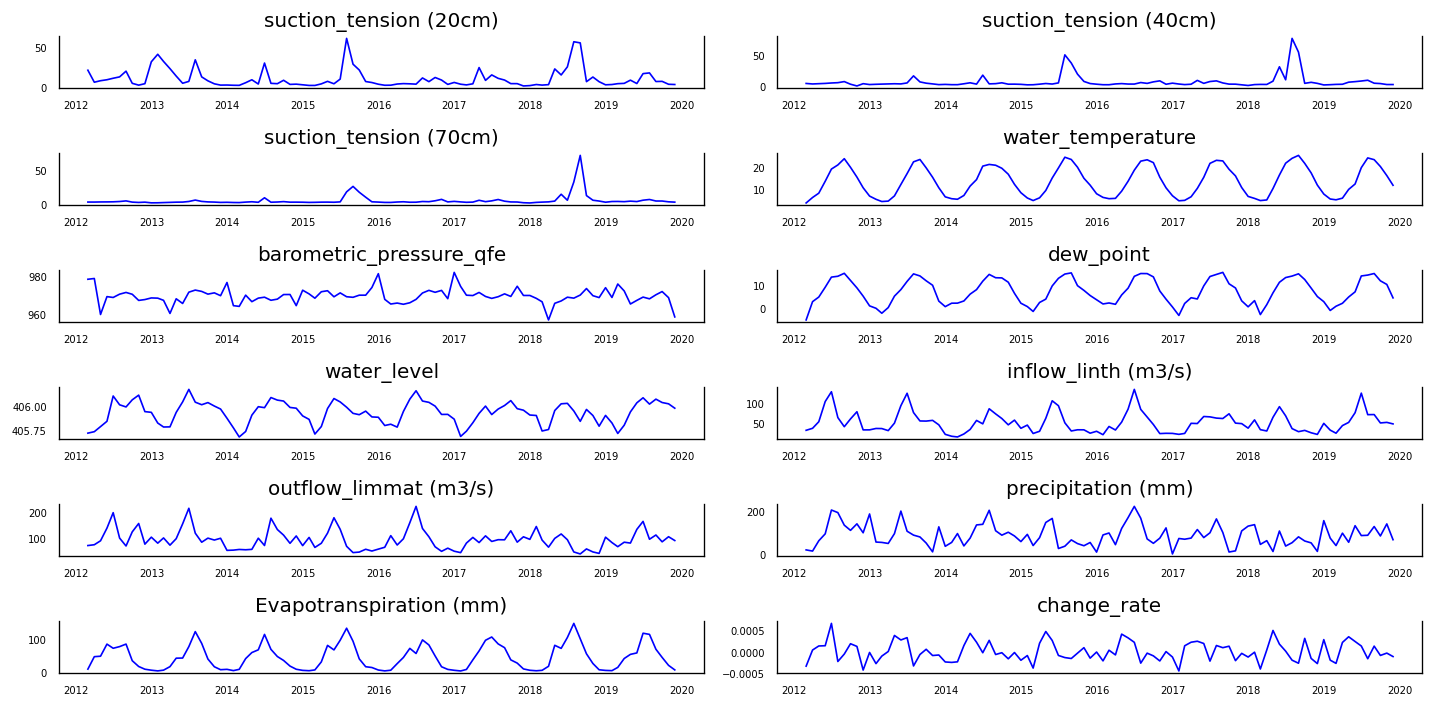

In [32]:
#Plot all variables
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    monthly_data2 = monthly_data[monthly_data.columns[i]]
    ax.plot(monthly_data2, color='blue', linewidth=1)
    # Decorations
    ax.set_title(monthly_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

By looking at the plots we could hypothesize that there is some non-stationary, due to some seasonality.

**2. Testing the stationarity by using ADF and differencing the data**

In [33]:
for name, column in monthly_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.569
 No. Lags Chosen       = 0
 Critical value 1%     = -3.503
 Critical value 5%     = -2.893
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5539
 No. Lags Chosen       = 0
 Critical value 1%     = -3.503
 Critical value 5%     = -2.893
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

As we can see, evapotranspiration, water level, water temperature and dew point are non-stationary. We therefore need to difference the data to make it stationary.

In [34]:
#Let's difference the dataset in order to be sure that the data is stationary
monthly_data_differenced = monthly_data.diff().dropna()

In [35]:
#Let's test stationarity again.
for name, column in monthly_data_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.776
 No. Lags Chosen       = 1
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.2301
 No. Lags Chosen       = 1
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

Now all variables are stationary. We can therefore continue with the next step.

**3. Testing cointegration**

In [36]:
cointegration_test(monthly_data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
suction_tension (20cm) ::  916.71    > 311.1288  =>   True
suction_tension (40cm) ::  661.33    > 263.2603  =>   True
suction_tension (70cm) ::  483.21    > 219.4051  =>   True
water_temperature ::  321.78    > 179.5199  =>   True
barometric_pressure_qfe ::  226.88    > 143.6691  =>   True
dew_point ::  162.31    > 111.7797  =>   True
water_level ::  105.35    > 83.9383   =>   True
inflow_linth (m3/s) ::  58.82     > 60.0627   =>   False
outflow_limmat (m3/s) ::  38.01     > 40.1749   =>   False
precipitation (mm) ::  20.29     > 24.2761   =>   False
Evapotranspiration (mm) ::  7.12      > 12.3212   =>   False
change_rate ::  0.24      > 4.1296    =>   False


In this case we can see that we do not observe any cointegration for multiple variables. However, we can still test our model for short term relationships.

**4. Split the data into train, validation and test set.**

In [94]:
#Let's keep a copy of the undifferenced train, validation and test sets.
train_mo, test_mo = train_test_split(monthly_data, train_size=83) #train: 2012-(end of) 2018, test: 2019-(end of) 2019
train_val_mo, val_mo = train_test_split(train_mo, train_size=59) #train_val: 2012-(end of) 2016, val: 2017-(end of) 2018

In [38]:
#Let's now make train; validation and tests sets with the differenced data.
train_mo_differenced, test_mo_differenced = train_test_split(monthly_data_differenced, train_size=82)
train_val_mo_differenced, val_mo_differenced = train_test_split(train_mo_differenced, train_size=58)

**5. Checking the AIC score**

In [39]:
model_mo_VAR = VAR(train_val_mo_differenced) # initializes VAR object
model_mo_VAR.select_order(maxlags=3).summary()

,AIC,BIC,FPE,HQIC
0,16.31,16.75,1.215e+07,16.48
1,-2.484,3.210*,0.09308,-0.2819
2,-4.072,6.877,0.04031,0.1621
3,-11.93*,4.270,0.0002028*,-5.668*


The minimum AIC is at lag 3. However, we tested out other variables. Thus, we found out that for our validation set the optmal lag order is 2.

**6.1 Fitting the model with monthly data and all variables**

In [40]:
#Let's fit the model. 
#This is going to return the differenced train set and validation set.
VAR_wf_mo_test_diff, VAR_wf_mo_val_diff = walk_forward_VAR(train_val_mo_differenced, val_mo_differenced, 2, monthly_data)

In [41]:
#Let's invert the transformation just like we did for the weekly data.
train_wf_mo_validation_inverted = invert_transformation(train_val_mo, VAR_wf_mo_test_diff, first_diff=True)
wf_mo_validation_inverted = invert_transformation(train_val_mo, VAR_wf_mo_val_diff, first_diff=True)

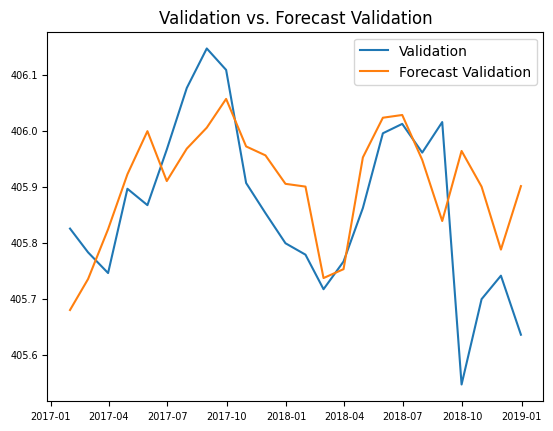

In [42]:
#Let's plot the validation set and the forecasted validation set
plt.plot(wf_mo_validation_inverted[["water_level"]].index, wf_mo_validation_inverted[["water_level"]], label="Validation")
plt.plot(train_wf_mo_validation_inverted[["water_level"]].index, train_wf_mo_validation_inverted[["water_level"]], label="Forecast Validation")
plt.title("Validation vs. Forecast Validation")
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.legend()
plt.show()

In [43]:
#Let's calculate the errors for the model with all variables
mean_errors(wf_mo_validation_inverted[["water_level"]], train_wf_mo_validation_inverted[["water_level"]])

MAE: 0.1029955903814231 
MSE: 0.018946401462570126 
MAPE: 0.025380782337588108 
R2: 0.14231309427439942


**6.2 Fitting the model with monthly data and selected variables (Granger's causality test)**

In order to fit the Granger's causality test, we are going to select the optimal order (the one we found after multiple validation tests).

In [140]:
get_grangers_causation_results(train_mo_differenced, 4, test='ssr_chi2test')

,suction_tension (20cm)_y,suction_tension (40cm)_y,suction_tension (70cm)_y,water_temperature_y,barometric_pressure_qfe_y,dew_point_y,water_level_y,inflow_linth (m3/s)_y,outflow_limmat (m3/s)_y,precipitation (mm)_y,Evapotranspiration (mm)_y,change_rate_y
suction_tension (20cm)_x,1.0000,0.0234,0.0000,0.0002,0.4848,0.1206,0.7018,0.4029,0.0995,0.0273,0.0023,0.7645
suction_tension (40cm)_x,0.3340,1.0000,0.0000,0.3452,0.8222,0.1868,0.0898,0.3464,0.1747,0.2205,0.0307,0.1241
suction_tension (70cm)_x,0.0097,0.0000,1.0000,0.3972,0.0199,0.7438,0.0223,0.3825,0.1330,0.1110,0.1062,0.0519
water_temperature_x,0.0002,0.0027,0.0193,1.0000,0.0005,0.0000,0.0000,0.0000,0.0002,0.0046,0.0000,0.0008
barometric_pressure_qfe_x,0.5693,0.2232,0.8727,0.0066,1.0000,0.1758,0.0025,0.0265,0.2807,0.0070,0.0027,0.0001
dew_point_x,0.2457,0.0288,0.0356,0.0161,0.0636,1.0000,0.0000,0.0001,0.0055,0.0033,0.0000,0.0002
water_level_x,0.0615,0.0331,0.0530,0.0000,0.0344,0.4566,1.0000,0.0028,0.0115,0.4662,0.0000,0.0000
inflow_linth (m3/s)_x,0.0004,0.0011,0.0245,0.0003,0.2092,0.0226,0.0036,1.0000,0.0012,0.2907,0.0000,0.0007
outflow_limmat (m3/s)_x,0.0053,0.0481,0.3724,0.0085,0.3085,0.1273,0.0005,0.0006,1.0000,0.3948,0.0000,0.0000
precipitation (mm)_x,0.0808,0.0100,0.2513,0.0714,0.0914,0.3144,0.2643,0.1994,0.0547,1.0000,0.0755,0.1458


We keep all variables that could help predict the water level (p value below 0.05).

In [141]:
#Let's keep a copy of the undifferenced train, validation and test sets.
train_mo1 = train_mo.drop(train_mo.columns[[0, 1, 9, 11]], axis=1) 
test_mo1 = test_mo.drop(test_mo.columns[[0, 1, 9, 11]], axis=1) 
train_val_mo1 = train_val_mo.drop(train_val_mo.columns[[0, 1, 9, 11]], axis=1) 
val_mo1 = val_mo.drop(val_mo.columns[[0, 1, 9, 11]], axis=1) 
#Let's now make train; validation and tests sets with the differenced data.
train_mo_differenced1 = train_mo_differenced.drop(train_mo_differenced.columns[[0, 1, 9, 11]], axis=1) 
test_mo_differenced1 = test_mo_differenced.drop(test_differenced.columns[[0, 1, 9, 11]], axis=1) 
train_val_mo_differenced1 = train_val_mo_differenced.drop(train_val_mo_differenced.columns[[0, 1, 9, 11]], axis=1) 
val_mo_differenced1 = val_mo_differenced.drop(val_mo_differenced.columns[[0, 1, 9, 11]], axis=1)

In [142]:
#Let's fit the model
VAR_wf_mo_test_diff1, VAR_wf_mo_val_diff1 = walk_forward_VAR(train_val_mo_differenced1, val_mo_differenced1, 3, monthly_data.drop(monthly_data.columns[[0, 1, 9, 11]], axis=1))

In [143]:
#Let's invert the transformation
train_wf_mo_validation_inverted1 = invert_transformation(train_val_mo1, VAR_wf_mo_test_diff1, first_diff=True) #Validation set inverted
wf_mo_validation_inverted1 = invert_transformation(train_val_mo1, VAR_wf_mo_val_diff1, first_diff=True) #Forecasted Validation set inverted

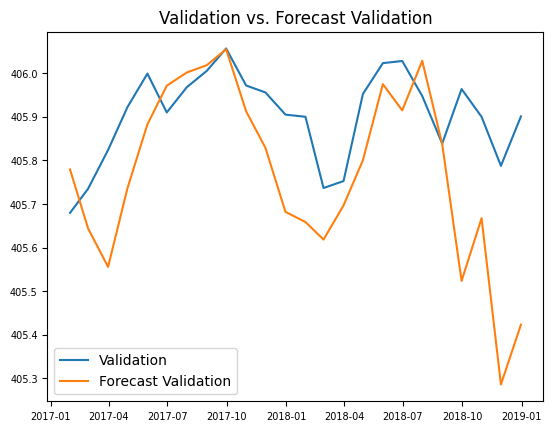

In [144]:
#Let's plot the validation set and the forecasted validation set
plt.plot(train_wf_mo_validation_inverted1[["water_level"]].index, train_wf_mo_validation_inverted1[["water_level"]], label="Validation")
plt.plot(wf_mo_validation_inverted1[["water_level"]].index, wf_mo_validation_inverted1[["water_level"]], label="Forecast Validation")
plt.title("Validation vs. Forecast Validation")
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.legend()
plt.show()

In [145]:
#Let's calculate the errors
mean_errors(train_wf_mo_validation_inverted1["water_level"], wf_mo_validation_inverted1["water_level"])

MAE: 0.15603765732218258 
MSE: 0.044209293214507644 
MAPE: 0.03844360430826108 
R2: -3.3142805868959755


**7. Final testing**

In [146]:
#Let's fit the model and ivert the variables for the monthly data with all variables
VAR_wf_mo_test_fc_diff, VAR_wf_mo_fc_diff = walk_forward_VAR(train_mo_differenced, test_mo_differenced, 2, monthly_data)
test_wf_mo_fc_inverted = invert_transformation(train_mo, VAR_wf_mo_test_fc_diff, first_diff=True)
forecast_wf_mo_inverted = invert_transformation(train_mo, VAR_wf_mo_fc_diff, first_diff=True)

In [147]:
#Let's fit the model and ivert the variables for the monthly data with selected variables
VAR_wf_mo_test_fc_diff1, VAR_wf_mo_fc_diff1 = walk_forward_VAR(train_mo_differenced1, test_mo_differenced1, 4, monthly_data.drop(monthly_data.columns[[0, 1, 9, 11]], axis=1))
test_wf_mo_validation_inverted1 = invert_transformation(train_mo1, VAR_wf_mo_test_fc_diff1, first_diff=True) 
forecast_mo_validation_inverted1 = invert_transformation(train_mo1, VAR_wf_mo_fc_diff1, first_diff=True) 

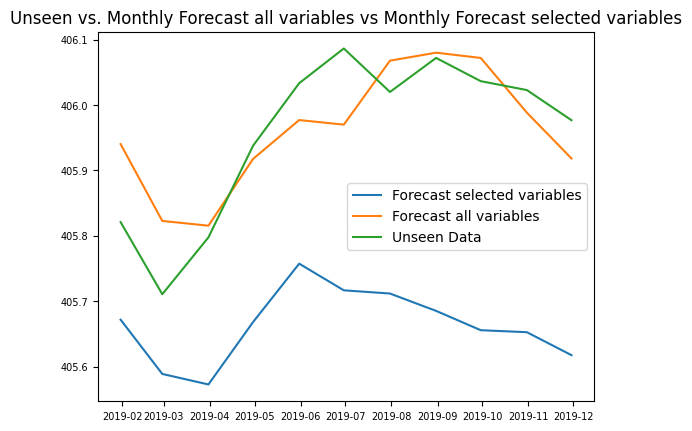

In [148]:
#Let's plot the test set and the forecast
plt.plot(forecast_mo_validation_inverted1[["water_level"]].index, forecast_mo_validation_inverted1[["water_level"]], label="Forecast selected variables")
plt.plot(forecast_wf_mo_inverted[["water_level"]].index, forecast_wf_mo_inverted[["water_level"]], label="Forecast all variables")
plt.plot(test_mo[["water_level"]].index, test_mo[["water_level"]], label="Unseen Data")
plt.title("Unseen vs. Monthly Forecast all variables vs Monthly Forecast selected variables")
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.legend()
plt.show()

In [149]:
#Errors for the model with all variables
mean_errors(test_mo[["water_level"]], forecast_wf_mo_inverted[["water_level"]])

MAE: 0.056992051118196614 
MSE: 0.004776038549014054 
MAPE: 0.014039903232534155 
R2: 0.6630712430069581


In [150]:
#Errors for the model with selected variables
mean_errors(test_mo1[["water_level"]], forecast_mo_validation_inverted1[["water_level"]])

MAE: 0.2925692441494489 
MSE: 0.09364264551331888 
MAPE: 0.07206330941439097 
R2: -5.606081552850077
